# Reducing Bias in Machine Learning Models:
### Modeling Part 1: Vanilla Models (Basic and Optimized)


#### Kristen Lo - BrainStation
---

### Table of Contents
- [Introduction](#intro)
- [Part 3: Vanilla Models (Basic and Optimized)](#clean)
    - 1.1: [Housekeeping](#house)
    - 1.2: [Logistic Regression](#log)
    - 1.3: [Random Forest](#tree)
    - 1.4: [Pre-processing Hospital Usage Data](#huse)
    - 1.5: [Pre-processing Historical Lab Data](#lab) 
    - 1.6: [Pre-processing Meds Data](#med) 
- [Conclusion](#conc)


---
### <a id = 'intro'></a> Introduction

In this notebook, we will be preparing our vanilla model and then optimizing it for performance. 

There is a need to be able to predict the hospital admission rates for diabetic patients. However, using traditional machine learning models can lead to health disparities caused by biased data which can be related to demographic data (ex. race, age, income, insurance etc). These biases need to be removed prior to modelling so that bias isn't introduced into the model. Building on the work of Raza, S. who aimed to predict, diagnose, and mitigate health disparities in hospital re-admission, my aim is to replicate the study performed by Raza and create my own model that's able to screen for biases and predict admission rates for diabetics visiting the ER. 


Data was sourced from all adult Emergency Department visits from March 2014 - July 2017 from one academic and two community emergency rooms, apart from the Yale New Haven Health system. These visits resulted in either admission to their respective hospital or discharge. 

There are a total of 972 variables that we extracted per patient visit from 560,486 patient visits. 

Courtesy of:
 "Hong WS, Haimovich AD, Taylor RA (2018) Predicting hospital admission at emergency department triage using machine learning. PLoS ONE 13(7): e0201016." (https://doi.org/10.1371/journal.pone.0201016)




-----

## <a id = 'clean'></a> Part 3: Vanilla Modelling (Basic and Optimized) 

---
#### <a id = 'housekeeping'></a> 1.1 HouseKeeping 

Loading the necessary libraries

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline as ImbPipeline

Loading the clean csv file

In [252]:
health_data = pd.read_csv('Data/clean_health_data_pt2.csv')

In [ ]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None) #Show all rows

In [ ]:
health_data.head()

,demo_gender,demo_race,disposition,pmh_2ndarymalig,pmh_abdomhernia,pmh_acqfootdef,pmh_acrenlfail,pmh_acutecvd,pmh_acutemi,pmh_acutphanm,pmh_adltrespfl,pmh_alcoholrelateddisorders,pmh_amniosdx,pmh_anemia,pmh_aneurysm,pmh_anxietydisorders,pmh_artembolism,pmh_asppneumon,pmh_asthma,pmh_attentiondeficitconductdisruptivebeha,pmh_biliarydx,pmh_bladdercncr,pmh_blindness,pmh_bnignutneo,pmh_bonectcncr,pmh_bph,pmh_brainnscan,pmh_breastcancr,pmh_breastdx,pmh_brnchlngca,pmh_cardiaarrst,pmh_carditis,pmh_cataract,pmh_chfnonhp,pmh_chrkidneydisease,pmh_coaghemrdx,pmh_coloncancer,pmh_comabrndmg,pmh_complicdevi,pmh_complicproc,pmh_conduction,pmh_contraceptiv,pmh_copd,pmh_coronathero,pmh_crushinjury,pmh_cysticfibro,pmh_deliriumdementiaamnesticothercognitiv,pmh_developmentaldisorders,pmh_diabmelnoc,pmh_diabmelwcm,pmh_disordersusuallydiagnosedininfancych,pmh_diverticulos,pmh_dizziness,pmh_dminpreg,pmh_dysrhythmia,pmh_ecodesadverseeffectsofmedicalcare,pmh_ecodesfall,pmh_ecodesfirearm,pmh_ecodesmotorvehicletrafficmvt,pmh_ecodesotherspecifiedandclassifiable,pmh_encephalitis,pmh_endometrios,pmh_epilepsycnv,pmh_esophcancer,pmh_esophgealdx,pmh_eyeinfectn,pmh_femgenitca,pmh_feminfertil,pmh_fluidelcdx,pmh_fuo,pmh_fxarm,pmh_fxhip,pmh_fxskullfac,pmh_gangrene,pmh_gasduoulcer,pmh_gastritis,pmh_gastroent,pmh_giconganom,pmh_gihemorrhag,pmh_giperitcan,pmh_glaucoma,pmh_goutotcrys,pmh_guconganom,pmh_hdnckcancr,pmh_headachemig,pmh_hemorrpreg,pmh_hodgkinsds,pmh_hrtvalvedx,pmh_htn,pmh_htncomplicn,pmh_htninpreg,pmh_hyperlipidem,pmh_immunitydx,pmh_inducabortn,pmh_infectarth,pmh_influenza,pmh_infmalegen,pmh_intestinfct,pmh_intobstruct,pmh_intracrninj,pmh_jointinjury,pmh_kidnyrnlca,pmh_lateeffcvd,pmh_leukemias,pmh_liveribdca,pmh_lowbirthwt,pmh_lungexternl,pmh_lymphenlarg,pmh_maintchemr,pmh_maligneopls,pmh_meningitis,pmh_menstrualdx,pmh_miscellaneousmentalhealthdisorders,pmh_mooddisorders,pmh_mouthdx,pmh_ms,pmh_multmyeloma,pmh_mycoses,pmh_neoplsmunsp,pmh_nephritis,pmh_nonepithca,pmh_nonhodglym,pmh_nutritdefic,pmh_opnwndextr,pmh_osteoarthros,pmh_osteoporosis,pmh_otaftercare,pmh_otbnignneo,pmh_otbonedx,pmh_otcirculdx,pmh_otcomplbir,pmh_otconntiss,pmh_otdxbladdr,pmh_otdxkidney,pmh_otdxstomch,pmh_otendodsor,pmh_otfemalgen,pmh_othbactinf,pmh_othcnsinfx,pmh_othematldx,pmh_othercvd,pmh_othereardx,pmh_otheredcns,pmh_othereyedx,pmh_othergidx,pmh_othergudx,pmh_otherinjury,pmh_otherpregnancyanddeliveryincludingnormal,pmh_otherscreen,pmh_othfracture,pmh_othheartdx,pmh_othliverdx,pmh_othlowresp,pmh_othmalegen,pmh_othnervdx,pmh_othveindx,pmh_otinflskin,pmh_otitismedia,pmh_otjointdx,pmh_otnutritdx,pmh_otprimryca,pmh_otrespirca,pmh_otupprresp,pmh_otuprspin,pmh_ovariancyst,pmh_pancreascan,pmh_pancreasdx,pmh_paralysis,pmh_parkinsons,pmh_pathologfx,pmh_peripathero,pmh_peritonitis,pmh_personalitydisorders,pmh_phlebitis,pmh_pid,pmh_pleurisy,pmh_pneumonia,pmh_poisnotmed,pmh_precereoccl,pmh_prevcsectn,pmh_prolapse,pmh_prostatecan,pmh_pulmhartdx,pmh_rctmanusca,pmh_rehab,pmh_respdistres,pmh_retinaldx,pmh_rheumarth,pmh_schizophreniaandotherpsychoticdisorde,pmh_screeningandhistoryofmentalhealthan,pmh_septicemia,pmh_sexualinfxs,pmh_shock,pmh_sicklecell,pmh_skininfectn,pmh_skinmelanom,pmh_socialadmin,pmh_spincorinj,pmh_stomchcancr,pmh_substancerelateddisorders,pmh_suicideandintentionalselfinflictedin,pmh_superficinj,pmh_syncope,pmh_teethdx,pmh_testiscancr,pmh_thyroiddsor,pmh_tia,pmh_tonsillitis,pmh_ulceratcol,pmh_ulcerskin,pmh_unclassified,pmh_urinyorgca,pmh_uteruscancr,pmh_uti,pmh_varicosevn,pmh_viralinfect,pmh_whtblooddx,cc_abdominalcramping,cc_abdominaldistention,cc_abdominalpain,cc_abdominalpainpregnant,cc_abnormallab,cc_abscess,cc_addictionproblem,cc_alcoholintoxication,cc_alcoholproblem,cc_allergicreaction,cc_alteredmentalstatus,cc_animalbite,cc_ankleinjury,cc_anklepain,cc_anxiety,cc_arminjury,cc_armpain,cc_assaultvictim,cc_asthma,cc_backpain,cc_bleeding/bruising,cc_bodyfluidexposure,cc_breastpain,cc_breathingdifficulty,cc_burn,cc_cardiacarrest,cc_chestpain,cc_coldlikesymptoms,cc_confusion,cc_co

In [ ]:
health_data.shape

(105627, 443)

In [ ]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 443 entries, demo_gender to dum_huse__3-plus_hormones
dtypes: int64(443)
memory usage: 357.0 MB


Considering that all of the information is binary, int64 dtype is bloating the file unnecessarily. Let's convert it to int8 to conserve memory and assist in modeling.

In [ ]:
# Assuming df is your DataFrame
int64_columns = health_data.select_dtypes(include='int64').columns

# Convert selected columns to int8
health_data[int64_columns] = health_data[int64_columns].astype('int8')

In [ ]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 443 entries, demo_gender to dum_huse__3-plus_hormones
dtypes: int8(443)
memory usage: 44.6 MB


As we can see, the memory usage has decreased from 357 mb to 44.6mb. This should be less computationally intensive.

---
#### <a id = 'log'></a> 1.2 Logistic Regression 

Before we can use Log regression, we must make sure that this data satisfies the assumptions. First is to double check if any multicolinearity exists within the data set. 

In [ ]:
#  Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Split to train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for multicollinearity
corr_matrix = X_train.corr()

# Identify highly correlated features
highly_correlated = np.where(np.abs(corr_matrix) > 0.7)

# Show the highly correlated features
features_to_drop = set()
for col1, col2 in zip(*highly_correlated):
    if col1 != col2 and col1 not in features_to_drop:
        features_to_drop.add(col2)
        print(f"Highly correlated features: {X_train.columns[col1]} and {X_train.columns[col2]}")


Highly correlated features: dum_triage_vital__no_hr_recorded and dum_triage_vital__no_rr_recorded
Highly correlated features: dum_triage_vital__no_hr_recorded and dum_triage_vital__no_temp_recorded
Highly correlated features: dum_huse__no_prior_visits and dum_hist_glucose_median__no_glucose_level_recorded
Highly correlated features: dum_huse__No_prior_admis and dum_hist_glucose_median__no_glucose_level_recorded


So there is multicolinearity that exists within the data set, but this makes sense. If a patient didn't have one `triage vital` recorded then it's highly unlikely that they would have the others since triage assessments are all done at the same time. From doing a little bit of digging, it was found that patients that arrive in emergent situations usually don't have `triage vitals` recorded as they are either rushed in by ambulance or taken quickly to treatment. 

Also the glucose level is the last lab value from a previous visit, so it makes sense why no prior admissions and no prior visits would be highly correlated to no glucose level In order to satisfy the assumptions, I will drop these columns from the original data frame. 

In [ ]:
features_to_drop = [
    'dum_triage_vital__no_hr_recorded','dum_triage_vital__no_rr_recorded','dum_triage_vital__no_temp_recorded',
    'dum_huse__no_prior_visits','dum_huse__No_prior_admis', 'dum_hist_glucose_median__no_glucose_level_recorded'
]

#drop from the original data frame. 
health_data = health_data.drop(columns=features_to_drop)

Now to begin Logistic Regression, I will first run a baseline model with no modifications. I will not scale the data as this is unnecessary for a dataset that is made up of only binary values. However, if it was a different data set, I would scale it as per standard practice. I will include the evaluations for the model as well in the code.

Train Accuracy: 0.791765777919788
Test Accuracy: 0.7927198712486982

Train Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81     45721
           1       0.80      0.73      0.76     38780

    accuracy                           0.79     84501
   macro avg       0.79      0.79      0.79     84501
weighted avg       0.79      0.79      0.79     84501


Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81     11348
           1       0.80      0.74      0.77      9778

    accuracy                           0.79     21126
   macro avg       0.79      0.79      0.79     21126
weighted avg       0.79      0.79      0.79     21126


Confusion Matrix (Test):
 [[9529 1819]
 [2560 7218]]


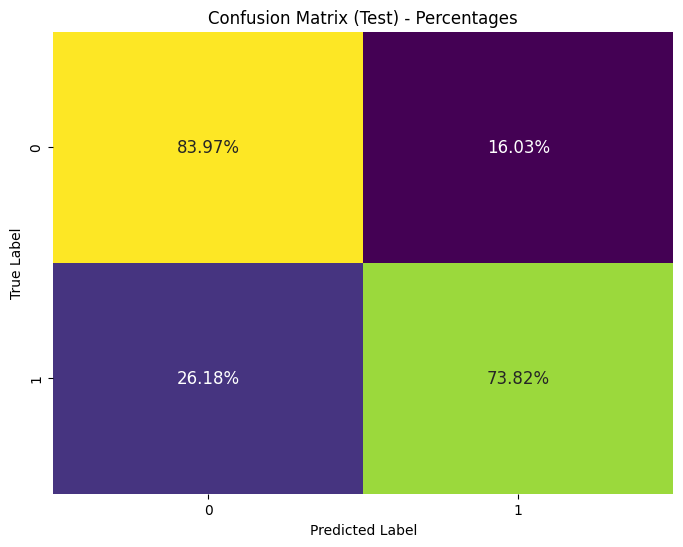

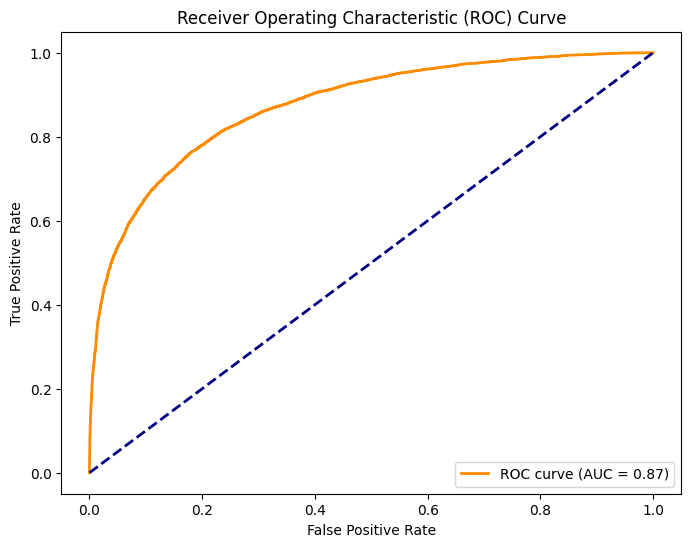

In [ ]:
#  Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Split to train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)  
logreg.fit(X_train, y_train)

# Predictions
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

# Accuracy Scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Train Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)

# Classification Reports
print('\nTrain Classification Report:\n', classification_report(y_train, y_train_pred))
print('\nTest Classification Report:\n', classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix_test)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix_test / conf_matrix_test.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict probabilities for ROC curve
y_test_prob = logreg.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate AUC score
roc_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Takeaways: 

Train Accuracy: 0.7918, Test Accuracy: 0.7927
- The log model is achieving around 79.2% accuracy on the training set and 79.3% accuracy on the test set.
- The test accuracy is similar to the training accuracy, suggesting that the log model generalizes reasonably well to new, unseen data.

Train Classification Report:
- For class 0 (negative), precision is 79%, recall is 84%, and F1-score is 821
        - Precision (79%): Out of all instances predicted as Class 0, 79% were correctly predicted. This means the model has a relatively low rate of false positives for Class 0.
        - Recall (84%): Out of all actual instances of Class 0, the model correctly identified 84% of them. This indicates a good ability to capture actual negatives
        - F1-Score (81%): The F1-Score, which balances precision and recall, is 82%. This suggests a good overall performance for predicting instances of Class 0.
    - For Class 0, the model is slightly better at recall (capturing actual negatives) than precision (avoiding false positives).
- For class 1 (positive), precision is 80%, recall is 74%, and F1-score is 77%.
    - Class 1 (Positive Class):
        - Precision (80%): Out of all instances predicted as Class 1, 80% were correctly predicted. This means the model has a relatively low rate of false positives for Class 1.
        - Recall (74%): Out of all actual instances of Class 1, the model correctly identified 74% of them. This indicates a good ability to capture actual positives, although it's somewhat lower than Class 0.
        - F1-Score (77%): The F1-Score, which balances precision and recall, is 77%. This suggests a good overall performance for predicting instances of Class 1.
    - For Class 1, the model is slightly better at precision (avoiding false positives) than recall (capturing actual positives).


Confusion Matrix (Test):
- It indicates that the log model is performing well in correctly predicting both classes, but it has some false positives and false negatives.

An AUC of 0.87 suggests that the model is performing well, with a high probability of ranking a randomly chosen positive instance higher than a randomly chosen negative instance. It's a positive sign that the model is effective in distinguishing between the classes.

---
**Optimizing the Logistic Regression**

The log model has a decent accuracy, but further analysis might be needed to understand and potentially improve its performance, especially in terms of reducing false positives and false negatives

In order to optimize this logreg model, let's approach the problem with the following steps:
- Let's first see if using oversampling (balancing the classes) will improve the model.
- Then let's apply Recursive Feature Elimination (RFE) or some form of feature elimination to only use the most relevant features that affect our target variable.

Class distribution before oversampling:
disposition
0    45721
1    38780
Name: count, dtype: int64

Class distribution after oversampling:
disposition
0    45721
1    45721
Name: count, dtype: int64

Test Accuracy: 0.7884597178831771

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80     11348
           1       0.77      0.77      0.77      9778

    accuracy                           0.79     21126
   macro avg       0.79      0.79      0.79     21126
weighted avg       0.79      0.79      0.79     21126


Confusion Matrix (Test):
 [[9127 2221]
 [2248 7530]]


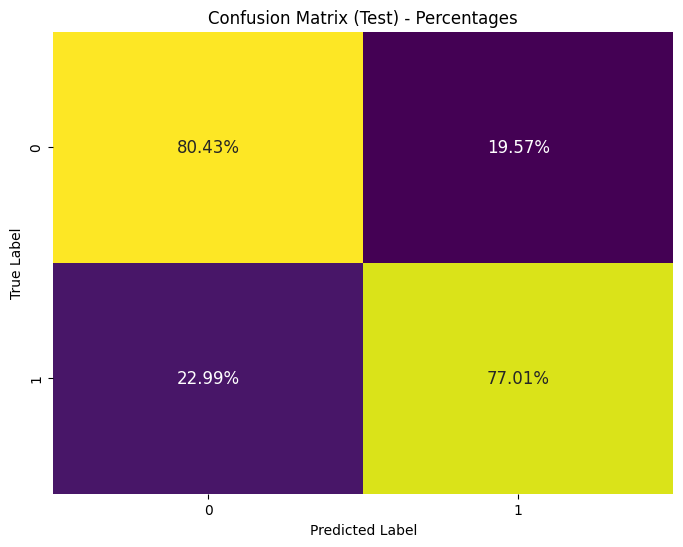

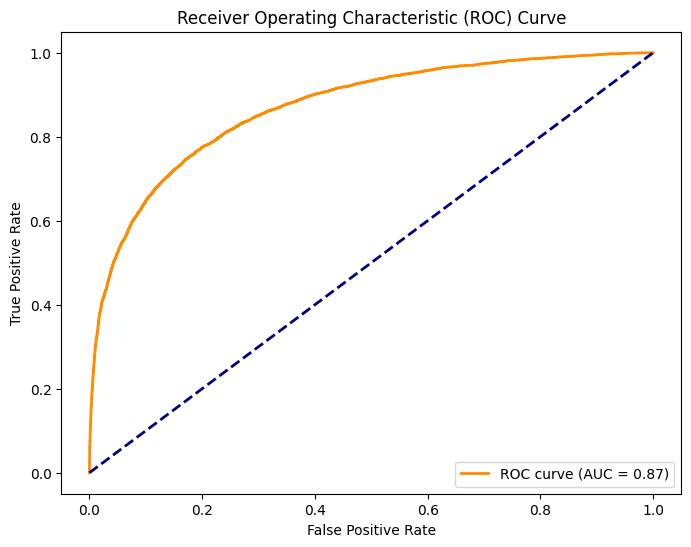

In [ ]:
# Check the class distribution before oversampling
print('Class distribution before oversampling:')
print(y_train.value_counts())

# Oversampling using SMOTE
oversampler = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print('\nClass distribution after oversampling:')
print(y_train_oversampled.value_counts())

# Train your model (e.g., Logistic Regression) on the oversampled data
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_oversampled, y_train_oversampled)

# Predictions
y_test_pred = logreg.predict(X_test)

# Evaluate the model
print('\nTest Accuracy:', accuracy_score(y_test, y_test_pred))
print('\nClassification Report:\n', classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix_test)

# Create a heatmap with the percentages
conf_matrix_percent = conf_matrix_test / conf_matrix_test.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict probabilities for ROC curve
y_test_prob = logreg.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate AUC score
roc_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Comparison:
- Accuracy: The accuracy is slightly lower after oversampling, but the classes are now balanced.
- Precision: Precision for Class 0 has increased, but for Class 1, it has decreased slightly.
- Recall: Recall for both classes is more balanced after oversampling.
- F1-Score: F1-Score is comparable between the two scenarios.

In general, after oversampling the classes are now balanced but performance is not that different from the baseline model. 
________

**Feature Elimination**

Now moving onto feature elimination, RFE attempts has been too computationally intensive. Instead, I will run a lasso regression to do some feature selection, any one that hits 0 first will be removed from the train/test data set. 

In [ ]:
health_data.shape[1]

437

We will be starting with 437 features. Let's first see what kind of hyper parameters might help the log model perform better. Let's find the best C value. We will be sure to continue to use the oversampled train x and y.

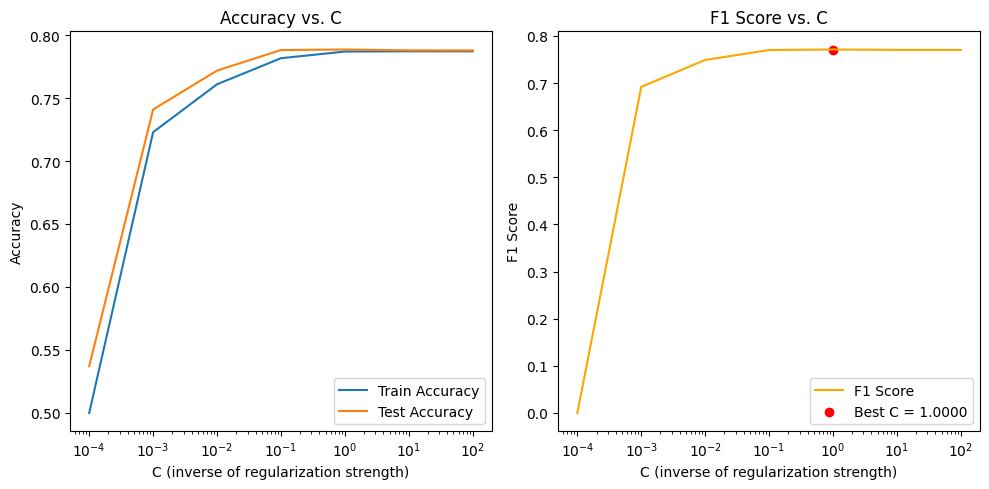

Best C value: 1.0


In [ ]:
# Range of C values to test
C_values = np.logspace(-4, 2, 7)

# Lists to store accuracy and F1 score
train_accuracy = []
test_accuracy = []
f1_scores = []

# Variable to store the best C value
best_C = None
best_f1_score = 0  # Initialize with a low value

# Loop through each C value
for C_val in C_values:
    # Create a logistic regression model with L1 penalty
    estimator_l1 = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', C=C_val)

    # Train the model
    estimator_l1.fit(X_train_oversampled, y_train_oversampled)

    # Predict on the training set
    y_train_pred = estimator_l1.predict(X_train_oversampled)

    # Predict on the test set
    y_test_pred = estimator_l1.predict(X_test)

    # Calculate accuracy for training and test sets
    train_accuracy.append(accuracy_score(y_train_oversampled, y_train_pred))
    test_accuracy.append(accuracy_score(y_test, y_test_pred))

    # Calculate F1 score for the test set
    f1 = f1_score(y_test, y_test_pred)
    f1_scores.append(f1)

    # Update best C value if needed
    if f1 > best_f1_score:
        best_f1_score = f1
        best_C = C_val

# Plot the results
plt.figure(figsize=(10, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(C_values, train_accuracy, label='Train Accuracy')
plt.plot(C_values, test_accuracy, label='Test Accuracy')
plt.xscale('log')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. C')

# Plot F1 score
plt.subplot(1, 2, 2)
plt.plot(C_values, f1_scores, label='F1 Score', color='orange')
plt.scatter(best_C, best_f1_score, color='red', marker='o', label=f'Best C = {best_C:.4f}')
plt.xscale('log')
plt.xlabel('C (inverse of regularization strength)')
plt.ylabel('F1 Score')
plt.legend()
plt.title('F1 Score vs. C')

plt.tight_layout()
plt.show()

# Print the best C value
print(f"Best C value: {best_C}")

It was found that the best C value was 1.0. We will implement this into the next iteration of the log model as well as using the oversampled (but balanced) train data. 

In [ ]:
# Choose logistic regression with L1 regularization (penalty='l1')
estimator_l1 = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear',C = 1.0)

# Fit logistic regression with L1 regularization on oversampled training data for the subset
estimator_l1.fit(X_train_oversampled, y_train_oversampled)

# Get the coefficients and corresponding feature names
coefficients_l1 = estimator_l1.coef_[0]
feature_names = X.columns

# Get indices of features with non-zero coefficients
non_zero_indices_l1 = np.where(coefficients_l1 != 0)[0]

print(f'The total number of relevant columns is:{non_zero_indices_l1.shape}') #Find the number of features left after feature selection

# Print the features with non-zero coefficients
print("\nFeatures with Non-Zero Coefficients (L1 Regularization):")
for idx in non_zero_indices_l1:
    print(f"Feature: {feature_names[idx]}, Coefficient: {coefficients_l1[idx]}")



The total number of relevant columns is:(418,)

Features with Non-Zero Coefficients (L1 Regularization):
Feature: demo_gender, Coefficient: 0.05266914007519593
Feature: demo_race, Coefficient: 0.17916446402553945
Feature: pmh_2ndarymalig, Coefficient: 0.4841688555354723
Feature: pmh_abdomhernia, Coefficient: 0.02225244385851145
Feature: pmh_acqfootdef, Coefficient: -0.11338023941582655
Feature: pmh_acrenlfail, Coefficient: 0.18546701551769865
Feature: pmh_acutecvd, Coefficient: 0.06906229949793814
Feature: pmh_acutemi, Coefficient: -0.0035690378791532603
Feature: pmh_acutphanm, Coefficient: 0.1268066350642224
Feature: pmh_adltrespfl, Coefficient: 0.03894915236263308
Feature: pmh_alcoholrelateddisorders, Coefficient: 0.20678615374146597
Feature: pmh_anemia, Coefficient: 0.1512561045703825
Feature: pmh_aneurysm, Coefficient: 0.013203017881203835
Feature: pmh_anxietydisorders, Coefficient: -0.07371520482085316
Feature: pmh_asppneumon, Coefficient: 0.11645852986985182
Feature: pmh_asthma, 

In [247]:
#Isolate irrelevant columns 
irrelevant_columns = health_data.columns.difference(feature_names[non_zero_indices_l1])

# Ensure 'disposition' is not in the irrelevant columns
irrelevant_columns = irrelevant_columns.difference(['disposition'])

# Display the number of irrelevant columns and their names
num_irrelevant_columns = len(irrelevant_columns)
print(f"Number of irrelevant columns: {num_irrelevant_columns}")
print("Irrelevant columns:", irrelevant_columns)

Number of irrelevant columns: 19
Irrelevant columns: Index(['cc_exposuretostd', 'cc_hemoptysis', 'cc_tachycardia', 'disposition',
       'pmh_amniosdx', 'pmh_artembolism', 'pmh_comabrndmg', 'pmh_dminpreg',
       'pmh_encephalitis', 'pmh_guconganom', 'pmh_lowbirthwt',
       'pmh_maintchemr', 'pmh_mycoses', 'pmh_otitismedia', 'pmh_prevcsectn',
       'pmh_rheumarth', 'pmh_tonsillitis', 'pmh_urinyorgca',
       'pmh_uteruscancr'],
      dtype='object')


In [248]:
health_data = health_data.drop(columns=irrelevant_columns) #dropping irrelevant columns

In [249]:
health_data.shape[1]#columns have been successfully dropped 

418

In [250]:
 health_data['disposition'].count()

KeyError: 'disposition'

After we evaluate the log reg coefficients with lasso, there are a total of 19 features that were removed. We will remove these from the original dataframe, then run the log reg model once more with the over-sampled data. 

In [223]:
health_data.columns.tolist()

['demo_gender',
 'demo_race',
 'pmh_2ndarymalig',
 'pmh_abdomhernia',
 'pmh_acqfootdef',
 'pmh_acrenlfail',
 'pmh_acutecvd',
 'pmh_acutemi',
 'pmh_acutphanm',
 'pmh_adltrespfl',
 'pmh_alcoholrelateddisorders',
 'pmh_anemia',
 'pmh_aneurysm',
 'pmh_anxietydisorders',
 'pmh_asppneumon',
 'pmh_asthma',
 'pmh_attentiondeficitconductdisruptivebeha',
 'pmh_biliarydx',
 'pmh_bladdercncr',
 'pmh_blindness',
 'pmh_bnignutneo',
 'pmh_bonectcncr',
 'pmh_bph',
 'pmh_brainnscan',
 'pmh_breastcancr',
 'pmh_breastdx',
 'pmh_brnchlngca',
 'pmh_cardiaarrst',
 'pmh_carditis',
 'pmh_cataract',
 'pmh_chfnonhp',
 'pmh_chrkidneydisease',
 'pmh_coaghemrdx',
 'pmh_coloncancer',
 'pmh_complicdevi',
 'pmh_complicproc',
 'pmh_conduction',
 'pmh_contraceptiv',
 'pmh_copd',
 'pmh_coronathero',
 'pmh_crushinjury',
 'pmh_cysticfibro',
 'pmh_deliriumdementiaamnesticothercognitiv',
 'pmh_developmentaldisorders',
 'pmh_diabmelnoc',
 'pmh_diabmelwcm',
 'pmh_disordersusuallydiagnosedininfancych',
 'pmh_diverticulos',
 'p

In [220]:
#  Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Split to train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Oversampling using SMOTE
oversampler = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Train your final logistic regression model using the selected features on the training set
final_logreg_model = LogisticRegression(C = 1.0,max_iter=1000, penalty='l1', solver='liblinear')
final_logreg_model.fit(X_train_oversampled[:, non_zero_indices_l1], y_train)

# Make predictions on the training set
y_train_pred = final_logreg_model.predict(X_train_oversampled[:, non_zero_indices_l1])

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train_oversampled, y_train_pred)

print('Train Accuracy:', train_accuracy)

# Classification Reports for training set
print('\nTrain Classification Report:\n', classification_report(y_train_oversampled, y_train_pred))

# Confusion Matrix for training set
conf_matrix_train = confusion_matrix(y_train_oversampled, y_train_pred)
print('\nConfusion Matrix (Train):\n', conf_matrix_train)

# Calculate percentages for the confusion matrix on the training set
conf_matrix_percent_train = conf_matrix_train / conf_matrix_train.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the training set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_train, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Train) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Make predictions on the test set
y_test_pred = final_logreg_model.predict(X_test[:, non_zero_indices_l1])

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)

print('\nTest Accuracy:', test_accuracy)

# Classification Reports for test set
print('\nTest Classification Report:\n', classification_report(y_test, y_test_pred))

# Confusion Matrix for test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix_test)

# Calculate percentages for the confusion matrix on the test set
conf_matrix_percent_test = conf_matrix_test / conf_matrix_test.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent_test, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Predict probabilities for ROC curve on the test set
y_test_prob = final_logreg_model.predict_proba(X_test[:, non_zero_indices_l1])[:, 1]

# Calculate ROC curve on the test set
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)

# Calculate AUC score on the test set
roc_auc = roc_auc_score(y_test, y_test_prob)

# Plot ROC curve on the test set
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend(loc='lower right')
plt.show()

KeyError: "['disposition'] not found in axis"

Interpretation:
- Accuracy: The model is correct around 79.5% of the time on both the training and test sets.
- Precision: The ability of the classifier not to label a negative sample as positive (0) and vice versa (1) is approximately 79-80%.
- Recall: The model correctly identifies around 84% of the negative samples (0), and around 74% of the positive samples (1).
- F1-Score: A balance between precision and recall is achieved, with an overall good performance.

When comparing the baseline model to the optimized model, there is little noticeable difference/improvement in terms of accuracy.

---
#### <a id = 'tree'></a> 1.3 Random Forest

In [73]:
#  Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

Test Accuracy: 0.7833948688819464

Test Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81     11348
           1       0.79      0.72      0.75      9778

    accuracy                           0.78     21126
   macro avg       0.78      0.78      0.78     21126
weighted avg       0.78      0.78      0.78     21126


Confusion Matrix (Test):
 [[9510 1838]
 [2738 7040]]


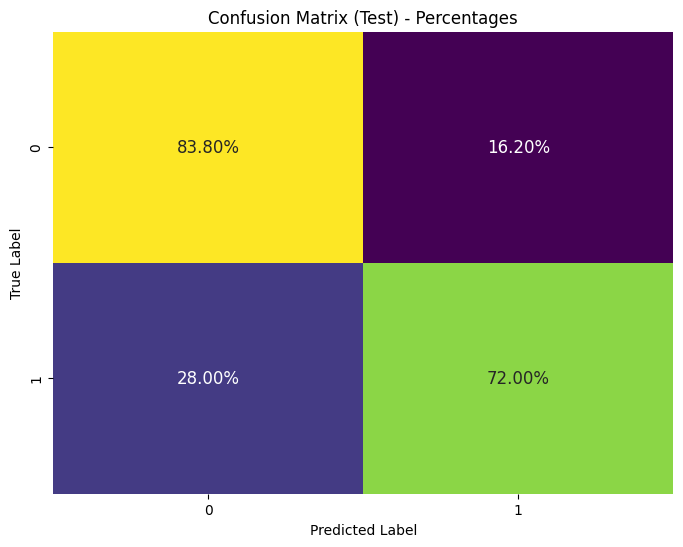

In [74]:
# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy)

# Classification Report
print('\nTest Classification Report:\n', classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()